In [21]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt

# Connect to WRDS (this will prompt for your username and password)
db = wrds.Connection("simengut")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [32]:

# SQL query to fetch the data
sql_query = """
SELECT 
    a.permno,
    a.date,
    b.ticker,
    b.comnam,
    b.cusip,
    a.prc,
    a.vol,
    a.ret
FROM 
    crsp.dsf AS a
JOIN 
    crsp.dsenames AS b
ON 
    a.permno = b.permno
WHERE 
    b.ticker IN ('PBW','PZD','QCLN','SMOG','PBD','GEX','TAN','FAN','ICLN')
    AND a.date BETWEEN '2000-01-01' AND '2024-12-31'
    AND a.date >= b.namedt
    AND a.date <= b.nameendt
ORDER BY 
    b.ticker,
    a.date;
"""

# Execute query and get results
df = db.raw_sql(sql_query)

# Display the first few rows
df.head()

,permno,date,ticker,comnam,cusip,prc,vol,ret
0,92695,2008-06-18,FAN,FIRST TRUST GLOBAL WIND ENER ETF,33736G10,31.36,458700.0,<NA>
1,92695,2008-06-19,FAN,FIRST TRUST GLOBAL WIND ENER ETF,33736G10,31.1,313800.0,-0.008291
2,92695,2008-06-20,FAN,FIRST TRUST GLOBAL WIND ENER ETF,33736G10,30.72,177700.0,-0.012219
3,92695,2008-06-23,FAN,FIRST TRUST GLOBAL WIND ENER ETF,33736G10,30.77,191100.0,0.001628
4,92695,2008-06-24,FAN,FIRST TRUST GLOBAL WIND ENER ETF,33736G10,30.27,119600.0,-0.01625


In [33]:
# find data range for db
# Find date range for each ETF
date_ranges = df.groupby('ticker').agg({
    'date': ['min', 'max']
}).reset_index()

# Rename columns for clarity
date_ranges.columns = ['Ticker', 'Start Date', 'End Date']

# Calculate number of trading days
date_ranges['Trading Days'] = df.groupby('ticker').size().values

# Format dates
date_ranges['Start Date'] = pd.to_datetime(date_ranges['Start Date']).dt.strftime('%Y-%m-%d')
date_ranges['End Date'] = pd.to_datetime(date_ranges['End Date']).dt.strftime('%Y-%m-%d')

# Display results
print("Date Ranges for Each ETF:")
display(date_ranges)


Date Ranges for Each ETF:


,Ticker,Start Date,End Date,Trading Days
0,FAN,2008-06-18,2024-12-31,4163
1,GEX,2005-04-13,2019-07-08,3535
2,ICLN,2008-06-25,2024-12-31,4158
3,PBD,2007-06-13,2024-12-31,4419
4,PBW,2005-03-03,2024-12-31,4992
5,PZD,2006-10-24,2021-03-24,3628
6,QCLN,2007-02-14,2024-12-31,4501
7,SMOG,2019-07-09,2024-12-31,1381
8,TAN,2000-01-03,2024-12-31,4311


Significant Data Gaps (>5 trading days):

FAN:
No significant gaps in data

GEX:
Number of significant gaps: 1
Gap periods:
  - Gap from 2007-02-28 to 2007-05-09 (69 trading days)

ICLN:
No significant gaps in data

PBD:
No significant gaps in data

PBW:
No significant gaps in data

PZD:
No significant gaps in data

QCLN:
No significant gaps in data

SMOG:
No significant gaps in data

TAN:
Number of significant gaps: 1
Gap periods:
  - Gap from 2000-05-30 to 2008-04-15 (2876 trading days)


ValueError: num must be an integer with 1 <= num <= 4, not 5

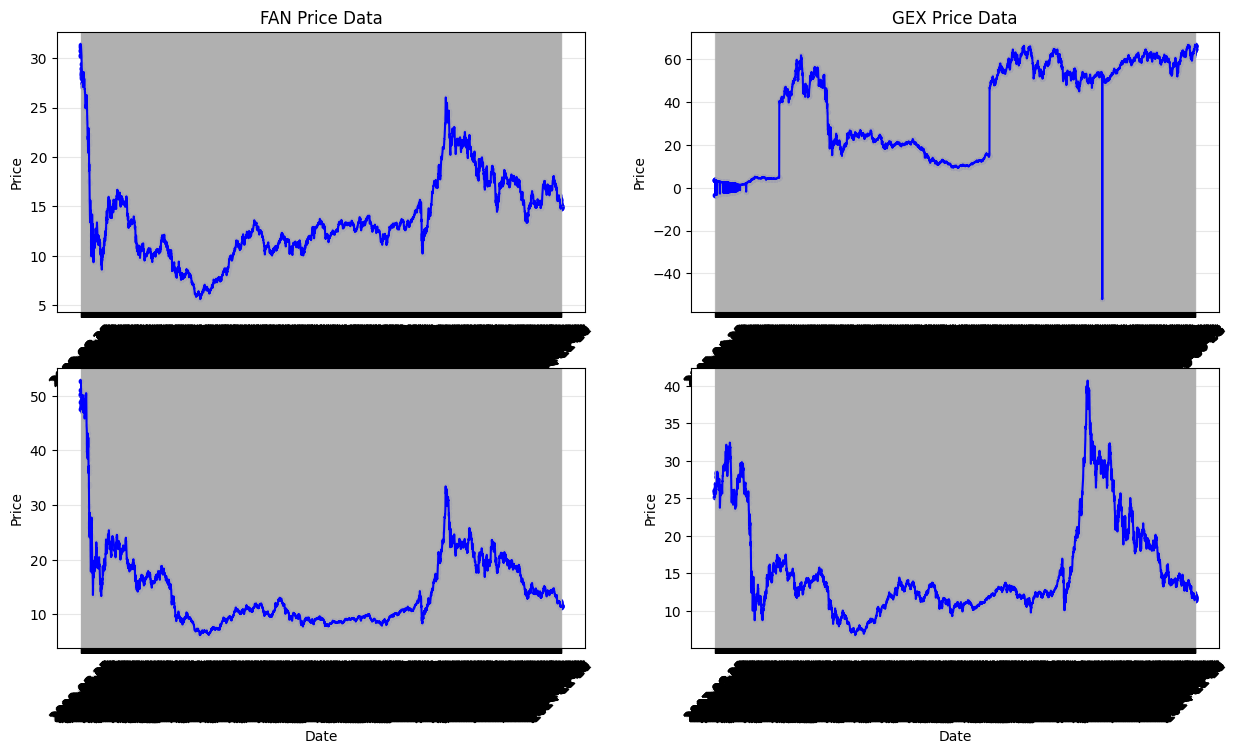

In [37]:
# Create a function to identify significant gaps in the data
def find_significant_gaps(df, ticker, min_gap_days=5):
    ticker_data = df[df['ticker'] == ticker].sort_values('date')
    ticker_data['date'] = pd.to_datetime(ticker_data['date'])
    ticker_data['date_diff'] = ticker_data['date'].diff()
    # Find gaps larger than min_gap_days
    gaps = ticker_data[ticker_data['date_diff'] > pd.Timedelta(days=min_gap_days)]
    return gaps

# Analyze significant gaps for each ticker
print("Significant Data Gaps (>5 trading days):")
for ticker in df['ticker'].unique():
    print(f"\n{ticker}:")
    gaps = find_significant_gaps(df, ticker)
    if len(gaps) > 0:
        print(f"Number of significant gaps: {len(gaps)}")
        print("Gap periods:")
        for _, row in gaps.iterrows():
            gap_start = row['date'] - row['date_diff']
            gap_end = row['date']
            gap_days = row['date_diff'].days - 1
            print(f"  - Gap from {gap_start.strftime('%Y-%m-%d')} to {gap_end.strftime('%Y-%m-%d')} ({gap_days} trading days)")
    else:
        print("No significant gaps in data")

# Visualize missing data patterns
plt.figure(figsize=(15, 8))
for i, ticker in enumerate(df['ticker'].unique()):
    ticker_data = df[df['ticker'] == ticker].sort_values('date')
    plt.subplot(2, 2, i+1)
    plt.plot(ticker_data['date'], ticker_data['prc'], 'b-', label='Price')
    plt.scatter(ticker_data['date'], ticker_data['prc'], s=10, c='b')
    plt.title(f'{ticker} Price Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check for specific missing patterns
print("\nMissing Data Summary by Year:")
for ticker in df['ticker'].unique():
    print(f"\n{ticker}:")
    ticker_data = df[df['ticker'] == ticker]
    ticker_data['date'] = pd.to_datetime(ticker_data['date'])
    yearly_counts = ticker_data.groupby(ticker_data['date'].dt.year).size()
    expected_days = 252  # Approximate number of trading days per year
    missing_years = []
    for year in range(2000, 2025):
        if year not in yearly_counts.index:
            missing_years.append(year)
        elif yearly_counts[year] < expected_days * 0.9:  # Less than 90% of expected days
            print(f"  {year}: Only {yearly_counts[year]} trading days ({(yearly_counts[year]/expected_days*100):.1f}% of expected)")
    if missing_years:
        print(f"  Missing entire years: {missing_years}")